# Condensed Matter Intro 
# to Jax and Autodiff
___

Simon Verret

April 24th, 2025

In [1]:
import os
from math import pi
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True)

# The `numpy` grid dillemma
___

In [2]:
list_kx = np.linspace(-pi, pi, 1000)
list_ky = np.linspace(-pi, pi, 1000)

print(f"""
    list_kx.shape: {list_kx.shape}
    list_ky.shape: {list_ky.shape}
""")


    list_kx.shape: (1000,)
    list_ky.shape: (1000,)



In [3]:
grid_kx, grid_ky = np.meshgrid(
    np.linspace(-pi, pi, 1000),
    np.linspace(-pi, pi, 1000),
)

print(f"""
    grid_kx.shape: {grid_kx.shape}
    grid_kx.shape: {grid_ky.shape}
""")


    grid_kx.shape: (1000, 1000)
    grid_kx.shape: (1000, 1000)



In [4]:
k_grid = np.stack([grid_kx, grid_ky])

print(f"""
    k_grid.shape: {k_grid.shape}
""")


    k_grid.shape: (2, 1000, 1000)



In [5]:
grid_k = np.stack([grid_kx, grid_ky], axis=-1)

print(f"""
    grid_k.shape: {grid_k.shape}
""")


    grid_k.shape: (1000, 1000, 2)



# Dispersion
___

In [6]:
def naive_dispersion(k, t=1, tp=-0.3, tpp=0.2, mu=-0.9):
    return (
        -2 * t * (np.cos(k[0]) + np.cos(k[1])) 
        -4 * tp * np.cos(k[0])*np.cos(k[1]) 
        -2 * tpp * (np.cos(2*k[0]) + np.cos(2*k[1]))
        - mu
    )

In [7]:
def loop_dispersion(grid_k):
    nx, ny, d = grid_k.shape
    result = np.empty(shape=(nx,ny))
    for i in range(nx):
        for j in range(ny):
            result[i,j] = naive_dispersion(grid_k[i,j]) 
    return result

print(f"""
    loop k_grid works: {loop_dispersion(grid_k).shape}
""")


    loop k_grid works: (1000, 1000)



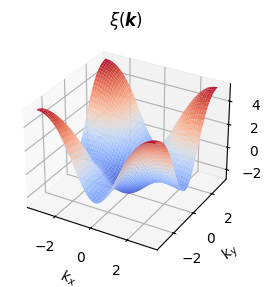

In [8]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_kx, grid_ky, loop_dispersion(grid_k), cmap='coolwarm')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
ax.set_title('$\\xi(\\boldsymbol{k})$')
plt.show()

In [9]:
%timeit loop_dispersion(grid_k)

2.58 s ± 10 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
grid_ek = naive_dispersion(k_grid)

print(f"""
    recall k_grid.shape = { k_grid.shape }
    direct call on k_grid works: { naive_dispersion(k_grid).shape }
""")


    recall k_grid.shape = (2, 1000, 1000)
    direct call on k_grid works: (1000, 1000)



In [11]:
%timeit naive_dispersion(k_grid)

18.2 ms ± 156 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(f"""
    recall grid_k.shape = { grid_k.shape }
    direct call on grid_k FAILS: { naive_dispersion(grid_k).shape }
""")


    recall grid_k.shape = (1000, 1000, 2)
    direct call on grid_k FAILS: (1000, 2)



In [13]:
def dispersion_for_grid(k, t=1, tp=-0.3, tpp=0.2, mu=0):
    kx, ky = np.split(k, 2, axis=-1)
    epsilon =  (
        -2 * t * (np.cos(kx) + np.cos(ky)) 
        -4 * tp * np.cos(kx)*np.cos(ky) 
        -2 * tpp * (np.cos(2*kx) + np.cos(2*ky))
    )
    return (epsilon - mu).squeeze()

print(f"""    
    recall grid_k.shape = { grid_k.shape }
    dispersion_for_grid on grid_k works: {dispersion_for_grid(grid_k).shape}
""")

    
    recall grid_k.shape = (1000, 1000, 2)
    dispersion_for_grid on grid_k works: (1000, 1000)



In [14]:
%timeit dispersion_for_grid(grid_k)

18.9 ms ± 179 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Enters JAX
___

In [15]:
import jax
import jax.numpy as jnp

def jax_naive_dispersion(k, t=1, tp=-0.3, tpp=0.2, mu=0):
    return (
        -2 * t * (jnp.cos(k[0]) + jnp.cos(k[1])) 
        -4 * tp * jnp.cos(k[0])*jnp.cos(k[1]) 
        -2 * tpp * (jnp.cos(2*k[0]) + jnp.cos(2*k[1]))
        - mu
    )

print(f"""
    recall k_grid.shape = { k_grid.shape }
    jax_naive on k_grid works: {jax_naive_dispersion(k_grid).shape}
""")


    recall k_grid.shape = (2, 1000, 1000)
    jax_naive on k_grid works: (1000, 1000)



In [16]:
%timeit jax_naive_dispersion(k_grid).block_until_ready()

8.63 ms ± 37.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `vmap`

In [17]:
from jax import vmap

In [18]:
vmap_naive = vmap(vmap(jax_naive_dispersion))

print(f"""
    recall grid_k.shape = { grid_k.shape }
    vmap_naive on grid_k works: {vmap_naive(grid_k).shape}
""")


    recall grid_k.shape = (1000, 1000, 2)
    vmap_naive on grid_k works: (1000, 1000)



In [19]:
%timeit vmap_naive(grid_k).block_until_ready()

16.3 ms ± 779 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
def jax_dispersion_for_grid(k, t=1, tp=-0.3, tpp=0.2, mu=0):
    kx, ky = jnp.split(k, 2, axis=-1)
    epsilon =  (
        -2 * t * (jnp.cos(kx) + jnp.cos(ky)) 
        -4 * tp * jnp.cos(kx)*jnp.cos(ky) 
        -2 * tpp * (jnp.cos(2*kx) + jnp.cos(2*ky))
    )
    return (epsilon - mu).squeeze()

print(f"""
    recall grid_k.shape = { grid_k.shape }
    jax made for grid_k works: { jax_dispersion_for_grid(grid_k).shape }
""")


    recall grid_k.shape = (1000, 1000, 2)
    jax made for grid_k works: (1000, 1000)



In [21]:
%timeit jax_dispersion_for_grid(grid_k).block_until_ready()

7.13 ms ± 114 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `jax.jit`

In [22]:
from jax import jit

In [23]:
jit_naive = jit(jax_naive_dispersion)

print(f"""
    recall k_grid.shape = { k_grid.shape }
    jit_naive on k_grid: {jit_naive(k_grid).shape}
""")


    recall k_grid.shape = (2, 1000, 1000)
    jit_naive on k_grid: (1000, 1000)



In [24]:
%timeit jit_naive(k_grid).block_until_ready()

3.34 ms ± 33.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
jit_vmap_naive = jit(vmap(vmap(jax_naive_dispersion)))

print(f"""
    recall grid_k.shape = { grid_k.shape }  
    jit_vmap_naive on grid_k works: { jit_vmap_naive(grid_k).shape }
""")


    recall grid_k.shape = (1000, 1000, 2)  
    jit_vmap_naive on grid_k works: (1000, 1000)



In [26]:
%timeit jit_vmap_naive(grid_k).block_until_ready()

3.44 ms ± 101 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
jit_for_grid = jit(jax_dispersion_for_grid)

print(f"""
    recall grid_k.shape = { grid_k.shape }  
    jit_for_grid works: {jit_for_grid(grid_k).shape}
""")


    recall grid_k.shape = (1000, 1000, 2)  
    jit_for_grid works: (1000, 1000)



In [28]:
%timeit jit_for_grid(grid_k).block_until_ready()

3.43 ms ± 53.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compared to `numba`

In [29]:
import numba

numba.njit()
def numba_naive(k, t=1, tp=-0.3, tpp=0.2, mu=0):
    epsilon =  (
        -2 * t * (jnp.cos(k[0]) + jnp.cos(k[1])) 
        -4 * tp * jnp.cos(k[0])*jnp.cos(k[1]) 
        -2 * tpp * (jnp.cos(2*k[0]) + jnp.cos(2*k[1]))
    )
    return epsilon - mu

print(f"""
    recall k_grid.shape = { k_grid.shape }  
    numba on k_grid works: {numba_naive(k_grid).shape}
""")


    recall k_grid.shape = (2, 1000, 1000)  
    numba on k_grid works: (1000, 1000)



In [30]:
%timeit numba_naive(k_grid)

6.25 ms ± 124 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `jax.pmap`

In [31]:
num_threads = jax.local_device_count()
Nx, Ny, d = grid_k.shape
newNx = Nx // num_threads

jax_paralelized_dispersion = jax.pmap(jax_dispersion_for_grid)
p_grid_k = grid_k.reshape(num_threads, newNx, Ny, d)

print(f"""
    Number of devices detected: {num_threads}
    1000hape p_grid_k accordingly: {p_grid_k.shape}
    jax paralelized works: {jax_paralelized_dispersion(p_grid_k).shape}
""")


    Number of devices detected: 8
    1000hape p_grid_k accordingly: (8, 125, 1000, 2)
    jax paralelized works: (8, 125, 1000)



In [32]:
%timeit jax_paralelized_dispersion(p_grid_k).reshape(Nx, Ny).block_until_ready()

3.73 ms ± 235 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## To good to be true? Yes!

In [33]:
low_res_grid_k = np.stack(np.meshgrid(
        np.linspace(-pi, pi, 100),
        np.linspace(-pi, pi, 100)
    ), axis=-1)

In [34]:
def jax_loop_dispersion_for_grid(grid_k):
    nx, ny, _ = grid_k.shape
    result = jnp.empty(shape=(nx, ny))
    for i in range(nx):
        for j in range(ny):
            result[i,j] = jax_naive_dispersion(grid_k[i,j])
            # result.at[i,j].set(jax_naive_dispersion(grid_k[i,j])) 
    return result

jit_loop = jit(jax_loop_dispersion_for_grid)

print(f"jax made for grid_k works: {jit_loop(low_res_grid_k).shape}")

jax made for grid_k works: (100, 100)


In [35]:
%timeit jit_loop(low_res_grid_k).block_until_ready()

3.62 μs ± 92.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Autodifferentiation
___

## `jax.grad`

In [36]:
from jax import grad

In [37]:
k_point = np.array([pi/4,pi])

grad_k_dispersion = grad(jax_naive_dispersion)

print(f"""
    grad value : {grad_k_dispersion(k_point)}
""")


    grad value : [3.06274 0.     ]



Autodifferentiation IS NOT finite differences

In [38]:
def finite_diff_grad_k_dispersion(k, dk=1e-4): 
    dkx = np.array([dk,0])
    ek_plus_dkx = jax_naive_dispersion(k_point + dkx)
    ek_minus_dkx = jax_naive_dispersion(k_point - dkx)
    grad_kx_ek = (ek_plus_dkx - ek_minus_dkx)/(2*dk)
    
    dky = np.array([0,dk])
    ek_plus_dky = jax_naive_dispersion(k_point + dky)
    ek_minus_dky = jax_naive_dispersion(k_point - dky)
    grad_ky_ek = (ek_plus_dky - ek_minus_dky)/(2*dk)
    
    return np.stack([grad_kx_ek, grad_ky_ek])

Autodifferentiation IS NOT symbolic differentiation

In [39]:

def symbolic_gradk_of_dispersion(k, t=1, tp=-0.3, tpp=0.2):
    kx, ky = jnp.split(k, 2, axis=-1)
    vkx =  (2 * t * jnp.sin(kx) + 4 * tp * jnp.sin(kx)*jnp.cos(ky) + 4 * tpp * jnp.sin(2*kx)).squeeze()
    vky =  (2 * t * jnp.sin(ky) + 4 * tp * jnp.cos(kx)*jnp.sin(ky) + 4 * tpp * jnp.sin(2*ky)).squeeze()
    return jnp.stack([vkx, vky], axis=-1)

In [40]:

print(f"""
    symbolic value        : {symbolic_gradk_of_dispersion(k_point)}
    jax.grad value         : {grad_k_dispersion(k_point)}
    finite difference 1e-5 : {finite_diff_grad_k_dispersion(k_point, 1e-5)}
    finite difference 1e-4 : {finite_diff_grad_k_dispersion(k_point, 1e-4)}
    finite difference 1e-3 : {finite_diff_grad_k_dispersion(k_point, 1e-3)}
    finite difference 1e-2 : {finite_diff_grad_k_dispersion(k_point, 1e-2)}
""")


    symbolic value        : [3.06274 0.     ]
    jax.grad value         : [3.06274 0.     ]
    finite difference 1e-5 : [3.05772 0.     ]
    finite difference 1e-4 : [3.06189 0.     ]
    finite difference 1e-3 : [3.06281 0.     ]
    finite difference 1e-2 : [3.06266 0.     ]



# Opening possibilities
___

## Group velocity

$$v_n(\boldsymbol k) = -\frac{1}{\hbar} \nabla_{\boldsymbol k} \epsilon(\boldsymbol k)$$

In [41]:
velocity = jit(vmap(vmap(grad(jax_naive_dispersion))))
vk_on_grid = velocity(grid_k)

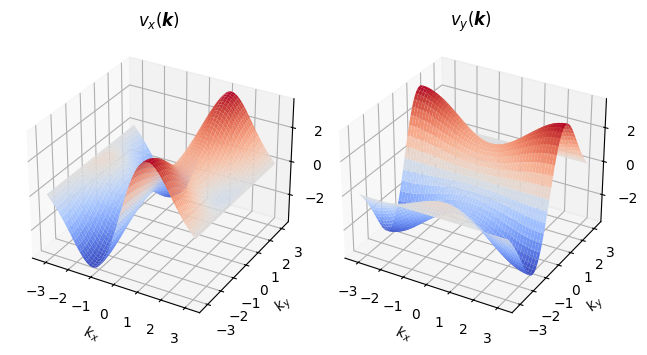

In [42]:

fig = plt.figure()

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(grid_kx, grid_ky, vk_on_grid[...,0], cmap='coolwarm')
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
ax1.set_title('$v_x(\\boldsymbol{k})$')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(grid_kx, grid_ky, vk_on_grid[...,1], cmap='coolwarm')
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
ax2.set_title('$v_y(\\boldsymbol{k})$')

plt.tight_layout()
plt.show()

In [43]:
%timeit velocity(grid_k)

2.73 ms ± 35.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
jit_symbolic_gradk_of_dispersion = jit(symbolic_gradk_of_dispersion)
vk_on_grid = jit_symbolic_gradk_of_dispersion(grid_k)
%timeit jit_symbolic_gradk_of_dispersion(grid_k)

3.77 ms ± 7.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Density of states

In [45]:
from tqdm import tqdm
dispersion = jit_for_grid

Usual spectral_weight approach to the density of state

$$ g(\epsilon) = \int d^2 k\, A(\boldsymbol k, \omega)  = \lim_{\eta\rightarrow 0}\int d^2 k\, \frac{1}{\pi} \frac{\eta}{(\omega - E(\boldsymbol k))^2 + \eta^2} $$

In [46]:
def spectral_weight_DOS(dispersion, grid_k, omega_list, eta):
    dos_list = []
    volume = np.prod(grid_k.shape)
    for omega in tqdm(omega_list):
        Akw = (1/pi) * eta/((omega - dispersion(grid_k))**2 + eta**2)
        dos_list.append(np.sum(Akw) * pi**2/volume)
    return dos_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 273.59it/s]


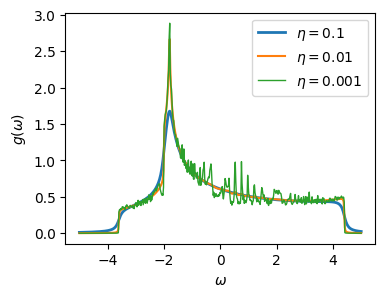

In [47]:
omega_list = jnp.linspace(-5,5,500)
fig, ax = plt.subplots(1,1, figsize=(4,3))
for i, eta in enumerate([0.1, 0.01, 0.001]):
    ax.plot(omega_list, spectral_weight_DOS(dispersion, grid_k, omega_list, eta), label=f"$\\eta = {eta}$", lw=2-i/2)
ax.legend()
ax.set_xlabel("$\\omega$")
ax.set_ylabel("$g(\\omega)$")
plt.show()

Alternative using the gradient: surface integral (A&M Eq.8.63) 

$$ g(\epsilon) = \int_{E_{k}=\epsilon} \frac{dS}{4\pi^3} \frac{1}{|\nabla_k E(k)|}$$

In [48]:
from skimage import measure

def fermi_surface_DOS(dispersion, omega_list, grid_k):
    grad_k_dispersion = jit(vmap(grad(dispersion)))
    dos_list = []
    for omega in tqdm(omega_list):    
        dos_value = 0

        ek_on_grid = dispersion(grid_k)
        contours = measure.find_contours(np.array(ek_on_grid), omega)
        for i, contour in enumerate(contours):
            contour = 2*pi * contour /(grid_k.shape[0] - 1) - pi

            diffs = np.diff(contour, axis=0)
            dl = np.linalg.norm(diffs, axis=-1)    
            midpoints = (contour[:-1] + contour[1:]) / 2
            dos_k = 1/np.linalg.norm(grad_k_dispersion(midpoints), axis=-1)

            dos_value += np.sum(dos_k * dl) / (pi**2)
        dos_list.append(dos_value)
    return np.array(dos_list)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 224.39it/s]


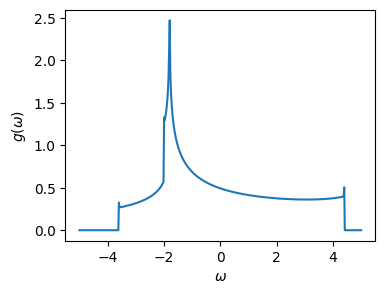

In [49]:
low_res = 100
low_res_grid_k = np.stack(np.meshgrid(
        np.linspace(-pi, pi, low_res),
        np.linspace(-pi, pi, low_res),
    ), axis=-1)

dos_list = fermi_surface_DOS(dispersion, omega_list, low_res_grid_k)

fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.plot(omega_list, dos_list)
ax.set_xlabel("$\\omega$")
ax.set_ylabel("$g(\\omega)$")
plt.show()

## Diagonalization

In [50]:

def af_bands(k=grid_k, xi=dispersion, m=1.5, Q=jnp.array([pi, pi])):
    coupling = m*jnp.ones(k.shape[:-1])
    h_on_grid = jnp.array([
        [xi(k)     , coupling ],
        [coupling  , xi(k + Q)],
    ])  # (2,2,...) --> # (...,2,2)
    h_on_grid = jnp.moveaxis(h_on_grid, (0,1), (-2,-1))  
    E_on_grid = jax.scipy.linalg.eigh(h_on_grid, eigvals_only=True)
    return E_on_grid[...,0], E_on_grid[...,1]

E1_on_grid, E2_on_grid = af_bands(grid_k)

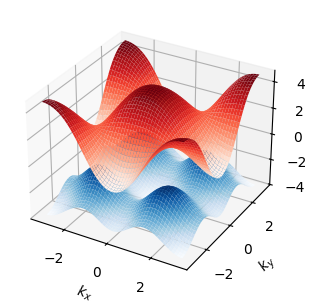

In [51]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(grid_kx, grid_ky, E1_on_grid, cmap='Blues')
ax.plot_surface(grid_kx, grid_ky, E2_on_grid, cmap='Reds')
ax.set_xlabel('$k_x$')
ax.set_ylabel('$k_y$')
plt.tight_layout()
plt.show()

In [52]:
def E1_func(k, m=.5):
    return af_bands(k, m=m)[0]

def E2_func(k, m=.5):
    return af_bands(k, m=m)[1]

v1_func = vmap(vmap(grad(E1_func)))
v2_func = vmap(vmap(grad(E2_func)))
v1_on_grid = v1_func(grid_k)
v2_on_grid = v2_func(grid_k)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 99.41it/s]


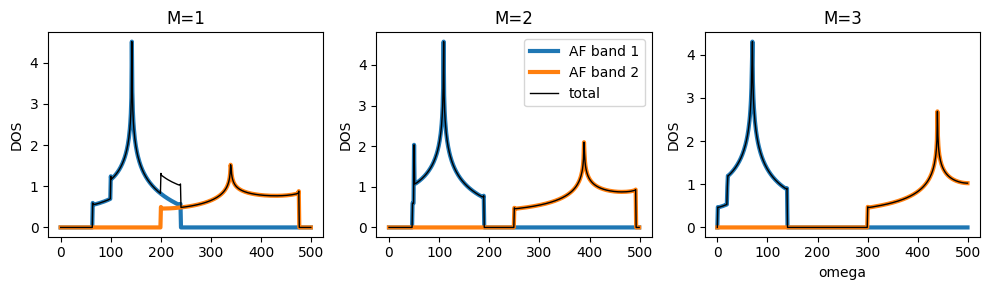

In [53]:
from functools import partial

dos_of_E = lambda E: fermi_surface_DOS(E, omega_list, low_res_grid_k)

fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)
for i, mval in enumerate([1, 2, 3]):
    
    E1_at_m = partial(E1_func, m=mval)
    E2_at_m = partial(E2_func, m=mval)
    
    ax[i].set_title(f"M={mval}")
    ax[i].plot(dos_of_E(E1_at_m), label="AF band 1", lw=3)
    ax[i].plot(dos_of_E(E2_at_m), label="AF band 2", lw=3)
    ax[i].plot(dos1+dos2, 'k', lw=1, label="total")
    ax[i].set_ylabel("DOS")
ax[1].legend()
ax[2].set_xlabel("omega")
plt.tight_layout()
plt.show()

## Root finding

$$f(\mu) = 2\int_{\rm BZ} d k\, \theta(\xi(k)-\mu) - n_0 = 0$$

In [54]:
from scipy import optimize

def filling(dispersion, grid_k):
    return 2*jnp.mean(jnp.greater_equal(0, dispersion(grid_k)))

def mu_at_filling(dispersion, grid_k, target_n):
    n_of_mu_minus_taget = lambda mu: filling(partial(dispersion, mu=mu), grid_k) - target_n
    return optimize.root(n_of_mu_minus_taget, (target_n-1)*3.5, method='hybr', jac=grad(n_of_mu_minus_taget)).x

In [55]:
target_n = 1.2
mu_star = mu_at_filling(jit(jax_dispersion_for_grid), grid_k, target_n)

print(f"""
    target_n    = {target_n},
    solution mu = {mu_star},
    n           = {filling(partial(jax_dispersion_for_grid, mu=mu_star), grid_k)}
""")


    target_n    = 1.2,
    solution mu = [0.27037],
    n           = 1.2000240087509155



### implicit function

In [56]:
n_of_mu = lambda mu: filling(partial(dispersion, mu=mu), grid_k)
mu_list = np.linspace(-5,5,100)
nofmu_list = [n_of_mu(mu) for mu in mu_list]

In [57]:
mu_of_n = partial(mu_at_filling, jit(jax_dispersion_for_grid), grid_k)
n_list = np.linspace(0,2,100)
muofn_list = [mu_of_n(n) for n in n_list]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.plot(nofmu_list, mu_list)
plt.plot(n_list, muofn_list)
ax.set_xlabel("$n$")
ax.set_xlim(0,2)
ax.set_ylabel("$\mu$")
ax.set_ylim(-5,5)

### Autodiff through implicit function?

In [ ]:
grad_mu_of_n = grad(mu_of_n)
grad_mu_of_n(n)

Can root finding for $\mu$ be seen as a fixed point equation?

If yes: [Implicit Layers Tutorial](https://implicit-layers-tutorial.org)


# TPSC
___

In [ ]:
raise NotImplementedError